Pierre Navaro - [Institut de Recherche Mathématique de Rennes](https://irmar.univ-rennes1.fr) - [CNRS](http://www.cnrs.fr/)

## References
* [Cython documentation](http://docs.cython.org/en/latest/)
* [An Interactive Introduction to Cython by Chris Swierczewski](http://www.cswiercz.info)
* [Introduction To Python by Michael Kraus](http://michael-kraus.org/introduction-to-python.html)
* [Cython by Xavier Juvigny 🇫🇷](http://calcul.math.cnrs.fr/IMG/pdf/cythontalk.pdf)
* [Cython: C-Extensions for Python, Wiki](https://github.com/cython/cython/wiki)
* Kurt W. Smith
    - [Cython A Guide for Python Programmers](http://shop.oreilly.com/product/0636920033431.do)
    - [Cython: Blend the Best of Python and C++ | SciPy 2015 Tutorial | Kurt Smith
](https://youtu.be/gMvkiQ-gOW8)
    - [Cython: Speed up Python and NumPy, Pythonize C, C++, and Fortran, SciPy2013 Kurt W. Smith](https://youtu.be/JKCjsRDffXo)
    - [SciPy 2017 - Cython by ](https://youtu.be/FepqwPI6U80)
    - [Cython Book examples](https://github.com/cythonbook)
    
* [Parallel computing in Cython/threads - Neal Hughes](http://nealhughes.net/parallelcomp2/)

![Cython logo](http://upload.wikimedia.org/wikipedia/en/thumb/c/ce/Cython-logo.svg/440px-Cython-logo.svg.png)

* Cython  provides extra syntax allowing for static type declarations (remember: Python is generally dynamically typed)
* Python code gets translated into optimised C/C++ code and compiled as Python extension modules
* Cython allows you to write fast C code in a Python-like syntax. 
* Furthermore, linking to existing C libraries is simplified.

```sh
pip3 install cython
conda install cython
```

# JupyterLab

For this session, you can use [JupyterLab](https://github.com/jupyterlab/jupyterlab)
a extensible computational environment for Jupyter.

If you use ``conda``:

```bash
conda install -c conda-forge jupyterlab
```

If you use ``pip``:

```bash
pip3 install jupyterlab
jupyter serverextension enable --py jupyterlab --sys-prefix
```

Start up JupyterLab in the notebooks-python directory:

```bash
jupyter lab
```

JupyterLab will open automatically in your browser.


# Pure Python Function


$f(x)=-2x^3+5x^2+x$,

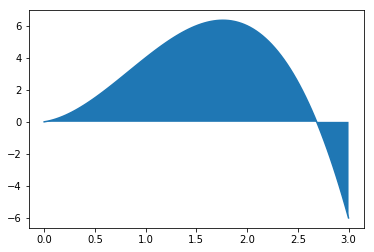

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def f(x):
    return -2*x**3 +5*x**2 +x

x = np.linspace(0,3,100)
ax = plt.subplot(1,1,1)
ax.plot(x, f(x))
ax.fill_between(x, 0, f(x));

 we compute integral $\int_a^b f(x)dx$ numerically with $N$ points.

In [24]:
def integrate_f_py(a,b,N):
    s  = 0
    dx = (b - a) / N
    for i in range(N):
        s += f(a + i*dx)
    return s*dx

In [8]:
%timeit integrate_f_py(0,3,10**3)
print(integrate_f_py(0,3,10))

NameError: name 'integrate_f_py' is not defined

In [9]:
https://pypi.python.org/pypi/py-heat-magic

SyntaxError: invalid syntax (<ipython-input-9-c09e82e7b636>, line 1)

In [5]:
%load_ext heat

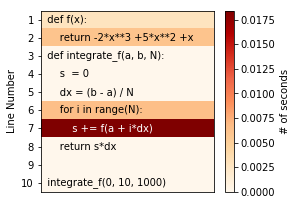

In [7]:
%%heat
def f(x):
    return -2*x**3 +5*x**2 +x
def integrate_f(a, b, N):
    s  = 0
    dx = (b - a) / N
    for i in range(N):
        s += f(a + i*dx)
    return s*dx

integrate_f(0, 10, 1000)

# Pure C function


In [8]:
%%file integral_f_c.c

#include <stdlib.h>
#include <stdio.h>
#include <time.h>

#define NB_RUNS 1000

double f(double x) {
    return -2*x*x*x +5*x*x +x;
}

double integrate_f_c(double a, double b, int N) {
    double s  = 0;
    double dx = (b - a) / N;
    for(int i=0; i<N; ++i)
        s += f(a + i*dx);
    return s*dx;
}

int main(int argc, char **argv)
{
  
  double a =  atof(argv[1]);
  double b =  atof(argv[2]);
  int N    =  atoi(argv[3]);
  double  res = 0;

  clock_t begin = clock();

  for (int i=0; i<NB_RUNS; ++i)
      res += integrate_f_c( a, b, N );
    
  clock_t end = clock();
     
  fprintf( stdout, "integral_f(%3.1f, %3.1f, %d) = %f \n", a, b, N, res / NB_RUNS );
  fprintf( stdout, "time = %e ms \n",  (double)(end - begin) / CLOCKS_PER_SEC );

  return 0;
}


Writing integral_f_c.c


In [9]:
!gcc -O3 integral_f_c.c; ./a.out 0 3 1000

integral_f(0.0, 3.0, 1000) = 9.008982 
time = 2.113000e-03 ms 


# Cython compilation: Generating C code

Load Cython in jupyter notebook.

In [6]:
%load_ext Cython

## C Variable and Type definitions

In general, use `cdef` to declare C variables. 
The command :
```sh
$ cython -a mycode.pyx
```
outputs an html file. It shows what parts of your code are C, which parts are Python, and where C-Python conversion occurs.

In [17]:
%%cython -a
cdef int i, j = 2, k = 3      # assigning values at declaration
i = 1                         # assigning values afterwards
# avoid Python-C conversion! It's expensive:
a = 5
i = a
# same with C-Python conversion:
b = j
print("a = %d" % a)
print("i = %d" % i)
print("b = %d" % b)

### Another Python vs. Cython coloring guide

In [18]:
%%cython -a

cdef int m
cdef int n
cdef double cy_total = 0.0
for m in range(10):
    n = 2*m
    cy_total += n
a = 0
b = 0
py_total = 0.0
for a in range(10):
    b = 2*a
    py_total += b
print(cy_total)
print(py_total)

In [19]:
%%cython -a
cdef struct Grail:
    int age
    float volume
cdef union Food:
    char *spam
    float *eggs
cdef enum CheeseType:
    cheddar, edam,
    camembert
cdef enum CheeseState:
    hard = 1
    soft = 2
    runny = 3
cdef Grail holy
holy.age    = 500
holy.volume = 10.0
print (holy.age, holy.volume)

# Cython Functions

Use **cdef** to define a Cython function.   
 - Cython function can accept either (inclusive) Python and C values as well as return either Python or C values,
 - *Within a Cython module* Python and Cython functions can call each other freely. However, only **Python** functions can be called from outside the module by Python code. (i.e. importing/exporting a Cython module into some Python code)

**cpdef** define a Cython function with a simple Python wrapper. However, when called from Cython the Cython / C code is called directly, bypassing the Python wrapper.  

Writing pure code in Cython gives a small speed boost. Note that none of the code below is Cython-specific. Just add `.pyx` instead of `.py` extension.

In [3]:
%%file cython_f_example.pyx
def f(x):
    return -2*x**3 +5*x**2 +x
def integrate_f(a, b, N):
    s  = 0
    dx = (b - a) / N
    for i in range(N):
        s += f(a + i*dx)
    return s*dx

Overwriting cython_f_example.pyx


# Cython Compilation

- The .pyx source file is compiled by Cython to a .c file.
- The .c source file contains the code of a Python extension module.
- The .c file is compiled by a C compiler to a .so (shared object library) file which can be imported directly into a Python session.

## Build with CMake
```cmake
project(cython_f_example CXX)
include(UseCython)  # Load Cython functions
# Set C++ output
set_source_file_properties(cython_f_example.pyx PROPERTIES CYTHON_IS_CXX TRUE )
# Build the extension module
cython_add_module( modname cython_f_example.pyx cython_f_example.cpp )
```

## C/C++ generation with cython application
```sh
cython -3 cython_f_example.pyx   # create the C file for Python 3
cython -3 --cplus cython_f_example.pyx  # create the C++ file for Python 3
```


## build with a C/C++ compiler
To build use the Makefile:
```make
CC=gcc
CFLAGS=`python-config --cflags` 
LDFLAGS=`python-config --ldflags`
cython_f_example:
	 ${CC} -c $@.c ${CFLAGS}
	 ${CC} $@.o -o $@.so -shared ${LDFLAGS}
```
Import the module in Python session
```python
import cython_f_example
```



# pyximport

import Cython .pyx files as if they were .py files:

In [1]:
import pyximport
pyximport.install()
import cython_f_example
%timeit cython_f_example.integrate_f(0,3,10**3)
print(cython_f_example.integrate_f(0,3,10))

293 µs ± 15.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.719999999999999


# Building a Cython module using distutils

Create the setup.py script:

In [2]:
%%file setup.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
  name = 'Cython Example Integrate f Function',
  ext_modules = cythonize("cython_f_example.pyx"),
)

Overwriting setup.py


In [3]:
%run setup.py build_ext --inplace

running build_ext


In [4]:
from cython_f_example import integrate_f
%timeit integrate_f(0,3,10*3)

9.57 µs ± 345 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# Why is it faster with Cython ?

- Python code is interpreted at every execution to machine code.
- Compiled C code is already in machine code.
- C is a statically-typed language. It gives to the compiler more information which allows it to optimize both computations and memory access.
- To add two variables, Python checks the type before calling the right __add__ function and store it to a value that can be new.
- C just add the variables and return the result.


# Add Cython types 
We coerce Python types to C types when calling the function. Still a "Python function" so callable from the global namespace.

In [7]:
%%cython
def f(x):
    return -2*x**3 +5*x**2 +x
def cy_integrate_f(double a, double b, int N):
    cdef int i
    cdef double s, dx
    s  = 0
    dx = (b - a) / N
    for i in range(N):
        s += f(a + i*dx)
    return s*dx

* typing the iterator variable i with C semantics, tells Cython to compile the for-loop to pure C code.
* typing a, s and dx is important as they are involved in arithmetic within the for-loop

* Cython type declarations can make the source code less readable
* Do not use them without good reason, i.e. only in performance critical sections.

In [31]:
%timeit cy_integrate_f(0,3,10**3)
print(cy_integrate_f(0,3,10))

251 µs ± 9.94 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.719999999999999


Finally, we integrate a Cython function instead of a Python function. 
This eliminates the Python-C conversion at the function call as seen 
above thus giving a pure Cython/C algorithm.

The primary downside is not being allowed to call
the function `cy_f`, from Python unless `cpdef` is used. 

In [32]:
%%cython
cdef double cy_f(double x):
     return -2*x**3 +5*x**2 +x
def cycy_integrate_f(double a, double b, int N):
    cdef int i
    cdef double s, dx
    s  = 0
    dx = (b - a) / N
    for i in range(N):
        s += cy_f(a + i*dx)
    return s*dx

In [33]:
%timeit cycy_integrate_f(0,3,10**3)
print(cycy_integrate_f(0,3,10))

22.8 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
9.719999999999999


# Exercice : Cythonize the trivial exponential function.

In [53]:
%%cython
def exp_python(x,terms=50):
   sum = 0.
   power = 1.
   fact = 1.
   for i in range(terms):
      sum += power/fact
      power *= x
      fact *= i+1
   return sum

In [67]:
%timeit exp_python(1.,50)

4.35 µs ± 194 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# Cython and Numpy

The Numpy library contains many fast numerics routines. Their speed comes 
from manipulating the low-level C-arrays that the numpy.array object wraps 
rather than computing over slow Python lists. Using Cython one can access 
those low-level arrays and implement their own fast algorithms while allowing 
the easy interaction afforded by Python + Numpy.

The examples below are various implementations of the naive matrix multiplication 
algorithm. We will start with a pure Python implementation and then incrementally 
add structures that allow Cython to exploit the low-level speed of the numpy.array 
object.

### Pure Python implementation compiled in Cython without specific optimizations.

In [54]:
%%cython
def matmul1(A, B, out=None):
    assert A.shape[1] == B.shape[0]
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            s = 0
            for k in range(A.shape[1]):
                s += A[i,k] * B[k,j]
            out[i,j] = s
    return out

# Import numpy as a Cython module

We now take advantage of the ability to access the underlying C arrays in the `numpy.array` object from Cython, thanks to a special `numpy.pxd` file included with Cython. (The Cython developers worked closely with Numpy developers to make this optimal.) 

To begin with, we have to `cimport` numpy: that is, import numpy as a **Cython** module rather than a **Python** module. To do so, simply type:

```python
cimport numpy as np
```
Another important thing to note is the type of Numpy indexers. There is a special Numpy variable type used for `numpy.array` indices called `Py_ssize_t`. To take full advantage of the speedups that Cython can provide we should make sure to type the variables used for indexing as such.


In [55]:
%%cython
import numpy as np
cimport numpy as np
ctypedef np.float64_t dtype_t      # shorthand type. easy to change
def matmul2(np.ndarray[dtype_t, ndim=2] A,
            np.ndarray[dtype_t, ndim=2] B,
            np.ndarray[dtype_t, ndim=2] out=None):
    cdef Py_ssize_t i, j, k
    cdef dtype_t s
    assert A.shape[1] == B.shape[0]
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            s = 0
            for k in range(A.shape[1]):
                s += A[i,k] * B[k,j]
            out[i,j] = s
    return out

In [56]:
import numpy as np
from timeit import timeit
A = np.random.random_sample((64,64))
B = np.random.random_sample((64,64))
C = np.zeros((64,64))

In [57]:
%timeit matmul1(A,B,C)

81.4 ms ± 3.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
%timeit matmul2(A,B,C)

352 µs ± 30 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Tuning indexing
The array lookups are still slowed down by two factors:
  * Bounds checking is performed.
  * Negative indices are checked for and handled correctly. 
  
The code doesn’t use negative indices, and always access to arrays within bounds. We can add a decorator to disable bounds checking:

In [59]:
%%cython
cimport cython                                       # cython tools
import numpy as np
cimport numpy as np
ctypedef np.float64_t dtype_t
@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def matmul3(np.ndarray[dtype_t, ndim=2] A,
            np.ndarray[dtype_t, ndim=2] B,
            np.ndarray[dtype_t, ndim=2] out=None):
    cdef Py_ssize_t i, j, k
    cdef dtype_t s
    assert A.shape[1] == B.shape[0]
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            s = 0
            for k in range(A.shape[1]):
                s += A[i,k] * B[k,j]
            out[i,j] = s
    return out

In [60]:
%timeit matmul3(A,B,C)

235 µs ± 14.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Cython Build Options

- boundcheck(True,False) : array bounds checking
- wraparound(True,False) : negative indexing.
- initializedcheck(True,False): checks that a memoryview is initialized 
- nonecheck(True,False) : Check if one argument is  None
- overflowcheck(True,False) : Check if int are too big
- cdivision(True,False) : If False, adjust the remainder and quotient operators C types to match those of Python ints. Could be very effective when it is set to True.
- profile (True / False) : Write hooks for Python profilers into the compiled C code. Default is False.

[Cython Compiler directives](http://docs.cython.org/en/latest/src/reference/compilation.html#compiler-directives)

# Numpy objects with external C program. 

Note that this can actually be slower 
because the C function is not the best implementation of matrix multiplication. Call cblas with same technique is an interesting exercice.

In [64]:
%%file mydgemm.c 
void my_dgemm( int m, int n, int k, 
              double a[m][n], double b[n][k], float c[m][k] )
{
  double ab = 0;
  for( int j = 0 ; j < m ; j++ ) {
    for( int i = 0 ; i < k ; i++ ) {
      for( int l = 0 ; l < n ; l++ ){
        ab += a[j][l] * b[l][i];
      }
      c[j][i] = ab ;
      ab = 0;
    }
  }
}

Overwriting mydgemm.c


- The `np.ndarray[double, ndim=2, mode="c"]` assures that you get a C-contiguous numpy array of doubles 
- The `&input[0,0]` passed in the address of the beginning of the data array.

In [68]:
%%cython

cdef extern from "/Users/navaro/notebooks-python/mydgemm.c":
    void my_dgemm (int m, int n, int k, 
                          double *A, double *B, double *C)
cimport cython
import numpy as np
cimport numpy as np
ctypedef np.float64_t dtype_t
@cython.boundscheck(False)
@cython.wraparound(False) 
def matmul4(np.ndarray[dtype_t, ndim=2, mode="c"] A,
            np.ndarray[dtype_t, ndim=2, mode="c"] B,
            np.ndarray[dtype_t, ndim=2, mode="c"] C=None):
    cdef int m = A.shape[0]
    cdef int n = A.shape[1]
    cdef int k = B.shape[1]
    cdef dtype_t s
    
    my_dgemm(m, n, k, &A[0,0], &B[0,0], &C[0,0])
                                                  
    return C

building '_cython_magic_aa9a40d0f7b5aa9fc0c4751f2cecf33d' extension
clang -Wno-unused-result -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/usr/local/lib/python3.6/site-packages/numpy/core/include -I/usr/local/lib/python3.6/site-packages/numpy/core/include -I/usr/local/lib/python3.6/site-packages/numpy/core/include -I/usr/local/lib/python3.6/site-packages/numpy/core/include -I/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/include/python3.6m -c /Users/navaro/.ipython/cython/_cython_magic_aa9a40d0f7b5aa9fc0c4751f2cecf33d.c -o /Users/navaro/.ipython/cython/Users/navaro/.ipython/cython/_cython_magic_aa9a40d0f7b5aa9fc0c4751f2cecf33d.o
clang -bundle -undefined dynamic_lookup /Users/navaro/.ipython/cython/Users/navaro/.ipython/cython/_cython_magic_aa9a40d0f7b5aa9fc0c4751f2cecf33d.o -o /Users/navaro/.ipython/cython/_cython_magic_aa9a40d0f7b5aa9fc0c4751f2cecf33d.cpython-36m-darwin.so


In [69]:
%timeit matmul4(A,B,C)

222 µs ± 13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Exercice : Find prime numbers < 10000

In [47]:
def is_prime0(n):
    if n == 2: return True
    if n % 2 == 0 or n < 2: return False
    k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True

In [48]:
[ p for p in range(20) if is_prime0(p)]

[2, 3, 5, 7, 11, 13, 17, 19]

In [49]:
L = list(range(10000))
%timeit [ p for p in L if is_prime0(p)]

8.51 ms ± 220 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
%%cython
def is_prime1(n):
    if n == 2: return True
    if n % 2 == 0 or n < 2: return False
    k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True

In [51]:
[ p for p in range(20) if is_prime1(p)]

[2, 3, 5, 7, 11, 13, 17, 19]

In [52]:
%timeit [p  for p in L if is_prime1(p)]

3.65 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Add Cython types without modifying the Python Code

In [53]:
%%cython
import cython
@cython.locals(n=int, k=int)
def is_prime2(n):
    if n == 2: return True
    if n % 2 == 0 or n < 2: return False
    k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True

In [59]:
[ p for p in range(20) if is_prime2(p)]

[2, 3, 5, 7, 11, 13, 17, 19]

In [60]:
%timeit [p for p in L if is_prime2(p) ]

703 µs ± 31.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Cython function 

In [64]:
%%cython
import cython
cdef bint is_prime3(int n):
    if n == 2: return True
    if n % 2 == 0 or n < 2: return False
    cdef int k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True
def prime_list(L):
    return [p for p in L if is_prime3(p)]

In [67]:
prime_list(list(range(20)))

[2, 3, 5, 7, 11, 13, 17, 19]

In [68]:
%timeit prime_list(L)

298 µs ± 17.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [70]:
%%cython
import cython
from numpy cimport ndarray
import numpy

cdef bint is_prime3(int n):
    if n == 2: return True
    if n % 2 == 0 or n < 2: return False
    cdef int k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True

def prime_array(ndarray[int, ndim=1] L):
    cdef ndarray[int, ndim=1] res = ndarray(shape=(L.shape[0]),dtype=numpy.int32)
    cdef int i
    for i in range(L.shape[0]):
        res[i] = is_prime3(L[i])
    return L[res==1]

In [75]:
import numpy as np
prime_array(np.arange(20,dtype=np.int32))

array([ 2,  3,  5,  7, 11, 13, 17, 19], dtype=int32)

In [76]:
npL = numpy.array(L,dtype=np.int32)
%timeit prime_array(npL)

301 µs ± 8.62 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Using Parallelism

* Cython supports native parallelism via OpenMP
* by default, Python’s Global Interpreter Lock (GIL) prevents that several threads use the Python interpreter simultaneously
* to use this kind of parallelism, the GIL must be released

If you have a default compiler with openmp support you can use
this magic command in your notebook.
```cython
%%cython --compile-args=-fopenmp --link-args=-fopenmp
```

In [77]:
%%file cython_omp.pyx
import cython
from cython.parallel cimport parallel, prange  # import parallel functions
import numpy as np
from numpy cimport ndarray

cdef bint is_prime4(int n) nogil:      #release the gil 
    if n == 2: return True
    if n % 2 == 0 or n < 2: return False
    cdef int k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True

@cython.boundscheck(False)
def prime_array_omp(ndarray[int, ndim=1] L):
    cdef ndarray[int, ndim=1] res = ndarray(shape=(L.shape[0]),dtype=np.int32)
    cdef Py_ssize_t i
    with nogil, parallel(num_threads=4):
        for i in prange(L.shape[0]):     #Parallel loop
            res[i] = is_prime4(L[i])
    return L[res==1]

Overwriting cython_omp.pyx


To use the OpenMP support, you need to enable OpenMP. For gcc this can be done as follows in a setup.py:

In [78]:
%%file setup.py
from distutils.core import setup
from distutils.extension import Extension
from Cython.Build import cythonize
import os
import numpy

os.environ["CC"] = "gcc-7"  # Change the compiler to gcc on Mac
os.environ["CXX"] = "g++-7"
ext_modules = [
    Extension(
        "cython_omp",
        ["cython_omp.pyx"],
        extra_compile_args=['-fopenmp'],
        extra_link_args=['-fopenmp'],
        include_dirs=[numpy.get_include()]
    )
]

setup(
    name='Cython OpenMP Example',
    ext_modules=cythonize(ext_modules),
)
# python setup.py build_ext --inplace

Overwriting setup.py


In [80]:
%run setup.py build_ext --inplace

running build_ext


In [83]:
from cython_omp import prime_array_omp

In [84]:
prime_array_omp(np.arange(20,dtype=np.int32))

array([ 2,  3,  5,  7, 11, 13, 17, 19], dtype=int32)

In [85]:
%timeit prime_array_omp(npL)

121 µs ± 517 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Solution: Trivial exponential function

In [86]:
%%cython
import cython
@cython.cdivision(True)
def exp_cython(double x, int terms = 50):
   cdef double sum
   cdef double power
   cdef double fact
   cdef int i
   sum = 0.
   power = 1.
   fact = 1.
   for i in range(terms):
      sum += power/fact
      power *= x
      fact *= i+1
   return sum

In [87]:
%timeit exp_cython(1.,50)

140 ns ± 3.35 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


# Wrapping Mersenne twister C++ class in Cython

Example MT_RNG Class from [K. W. Smith Book examples](https://github.com/cythonbook/examples)


In [ ]:
%rm -rf examples

In [1]:
%reset -f
!git clone https://github.com/cythonbook/examples.git

Cloning into 'examples'...
remote: Counting objects: 1737, done.
remote: Total 1737 (delta 0), reused 0 (delta 0), pack-reused 1737
Receiving objects: 100% (1737/1737), 934.05 KiB | 1.08 MiB/s, done.
Resolving deltas: 100% (827/827), done.


In [89]:
%cd /Users/navaro/notebooks-python/examples/08-wrapping-cxx/01-simple-example-mt_rng-class
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)  #Add the current directory to PYTHONPATH

/Users/navaro/notebooks-python/examples/08-wrapping-cxx/01-simple-example-mt_rng-class


A random generator is implemented in a C++ class with the following interface:

```C++
namespace mtrandom {

const static unsigned int N = 624;

class MT_RNG
{
  public:
    MT_RNG();
    MT_RNG(unsigned long s);
    MT_RNG(unsigned long init_key[], int key_length);

    // initializes RNG state, called by constructors.
    void init_genrand(unsigned long s);

    /* generates a random number on [0,0xffffffff]-interval */
    unsigned long genrand_int32();

    /* generates a random number on [0,0x7fffffff]-interval */
    long genrand_int31();

    /* generates a random number on [0,1]-real-interval */
    double genrand_real1();

    /* generates a random number on [0,1)-real-interval */
    double genrand_real2();

    /* generates a random number on (0,1)-real-interval */
    double genrand_real3();

    /* generates a random number on [0,1) with 53-bit resolution*/
    double genrand_res53();

    double operator()() {
      return genrand_real1();
    }

  private:

    unsigned long mt[N];
    int mti;
}; // class MT_RNG

} // namespace mtrandom
```

* Cython can only wrap public methods and members; any private or protected methods or members are not accessible, and thus not wrappable.
* To declare this class interface for use in Cython, we use an extern block as before. This extern block requires three additional elements to handle C++-isms:
    - Declaring the C++ namespace with the Cython namespace clause
    - Using the cppclass keyword to declare a C++ class interface block
    - Declaring the class’s interface in this block

```cython
# distutils: language = c++
# distutils: sources = mt19937.cpp

cdef extern from "mt19937.h" namespace "mtrandom":
    unsigned int N
    cdef cppclass MT_RNG:
        MT_RNG()
        MT_RNG(unsigned long s)
        MT_RNG(unsigned long init_key[], int key_length)
        void init_genrand(unsigned long s)
        unsigned long genrand_int32()
        double genrand_real1()
        double operator()()

cdef class RNG: # Wrapper extension type has a pointer 
                # to a heap-allocated instance of the C++ 
                # class it is wrapping:

    cdef MT_RNG *_thisptr

    # Method to create and initialize a valid MT_RNG object.
    def __cinit__(self, unsigned long s):
        self._thisptr = new MT_RNG(s)
        if self._thisptr == NULL:
            raise MemoryError()
    # Method for finalization.
    def __dealloc__(self):
        if self._thisptr != NULL:
            del self._thisptr

    # cpdef methods to generate random numbers from Python
    cpdef unsigned long randint(self):
        return self._thisptr.genrand_int32()

    cpdef double rand(self):
        return self._thisptr.genrand_real1()
```

# Compiling with C++

With compiler directives inside RNG.pyx, the
distutils script is simpler. 
```C
# distutils: language = c++
# distutils: sources = mt19937.cpp
```

In [100]:
%%file setup.py
from distutils.core import setup, Extension
from Cython.Build import cythonize

ext = Extension("RNG",
                sources=["RNG.pyx", "mt19937.cpp"],
                language="c++")

setup(name="RNG",
      ext_modules=cythonize(ext))

Overwriting setup.py


In [101]:
%run setup.py build_ext -if

running build_ext
building 'RNG' extension
gcc-7 -Wno-unused-result -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/usr/local/include -I/usr/local/opt/openssl/include -I/usr/local/opt/sqlite/include -I/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/include/python3.6m -c RNG.cpp -o build/temp.macosx-10.12-x86_64-3.6/RNG.o
gcc-7 -Wno-unused-result -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/usr/local/include -I/usr/local/opt/openssl/include -I/usr/local/opt/sqlite/include -I/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/include/python3.6m -c mt19937.cpp -o build/temp.macosx-10.12-x86_64-3.6/mt19937.o
g++-7 -bundle -undefined dynamic_lookup build/temp.macosx-10.12-x86_64-3.6/RNG.o build/temp.macosx-10.12-x86_64-3.6/mt19937.o -L/usr/local/lib -L/usr/local/opt/openssl/lib -L/usr/local/opt/sqlite/lib -o /Users/navaro/no

## Using the Wrapper from Python

In [102]:
from RNG import RNG
r = RNG(42)

In [103]:
r.randint(), r.randint()

(1608637542, 3421126067)

In [104]:
r.rand(), r.rand()

(0.9507143117838339, 0.1834347877147223)

## Overloaded Methods and Functions

The MT_RNG class has an alternate constructor that takes an array of unsigned longs to initialize the random-number generator’s state. How can we call this from Python?

We can do this by checking argument types of `__cinit__` method. We use an cython array which has a similar interface to a list, but it requires that all contained elements have the same scalar C type. Modify the RNG.pyx file:
```cython
from cpython.array cimport array
# ...
    def __cinit__(self, seed_or_state): 
        cdef array state_arr
        if isinstance(seed_or_state, int):
            self._thisptr = new MT_RNG(seed_or_state) 
        else:
            state_arr = array("L", seed_or_state)
            self._thisptr = new MT_RNG(state_arr.data.as_ulongs,
                                       len(state_arr))
```
If a list is passed to the constructor, it is converted to an array and passed to the second constructor.

*NumPy array could be used but it is less simple and introduces an external dependency.*

In [105]:
%%file RNG.pyx
# distutils: language = c++
# distutils: sources = mt19937.cpp
from cpython.array cimport array

cdef extern from "mt19937.h" namespace "mtrandom":
    unsigned int N
    cdef cppclass MT_RNG:
        MT_RNG()
        MT_RNG(unsigned long s)
        MT_RNG(unsigned long init_key[], int key_length)
        void init_genrand(unsigned long s)
        unsigned long genrand_int32()
        double genrand_real1()
        double operator()()

cdef class RNG:

    cdef MT_RNG *_thisptr

    def __cinit__(self, seed_or_state): 
        
        cdef array state_arr
        if isinstance(seed_or_state, int):
            self._thisptr = new MT_RNG(seed_or_state) 
        else:
            state_arr = array("L", seed_or_state)
            self._thisptr = new MT_RNG(state_arr.data.as_ulongs,
                                       len(state_arr))
        if self._thisptr == NULL:
            raise MemoryError()

    def __dealloc__(self):
        if self._thisptr != NULL:
            del self._thisptr

    cpdef unsigned long randint(self):
        return self._thisptr.genrand_int32()

    cpdef double rand(self):
        return self._thisptr.genrand_real1()


Overwriting RNG.pyx


In [106]:
%run setup.py build_ext -if

running build_ext
building 'RNG' extension
gcc-7 -Wno-unused-result -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/usr/local/include -I/usr/local/opt/openssl/include -I/usr/local/opt/sqlite/include -I/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/include/python3.6m -c RNG.cpp -o build/temp.macosx-10.12-x86_64-3.6/RNG.o
gcc-7 -Wno-unused-result -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/usr/local/include -I/usr/local/opt/openssl/include -I/usr/local/opt/sqlite/include -I/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/include/python3.6m -c mt19937.cpp -o build/temp.macosx-10.12-x86_64-3.6/mt19937.o
g++-7 -bundle -undefined dynamic_lookup build/temp.macosx-10.12-x86_64-3.6/RNG.o build/temp.macosx-10.12-x86_64-3.6/mt19937.o -L/usr/local/lib -L/usr/local/opt/openssl/lib -L/usr/local/opt/sqlite/lib -o /Users/navaro/no

** RESTART THE KERNEL BEFORE RUNNING THIS CELL ! **


In [1]:
%cd /Users/navaro/notebooks-python/examples/08-wrapping-cxx/01-simple-example-mt_rng-class

/Users/navaro/notebooks-python/examples/08-wrapping-cxx/01-simple-example-mt_rng-class


### Using the Wrapper from Python

In [2]:
from RNG import RNG
r2 = RNG(list(range(30,40)))

In [3]:
r2.rand()

0.04691027990703245

In [4]:
r2.randint()

2626217183

# Operator Overloading
- Cython supports most C++ operator overloads. 
- Currently, the in-place operators (+=, -=, etc.) are not supported. 
- Some operators are incompatible with Python’s syntax, so Cython provides a special [cython.operators](http://cython.readthedocs.io/en/latest/src/userguide/wrapping_CPlusPlus.html#c-operators-not-compatible-with-python-syntax) magic module to allow Python-compatible access. 

In [5]:
%%file RNG.pyx
# distutils: language = c++
# distutils: sources = mt19937.cpp
from cpython.array cimport array
from cython.operator cimport dereference as deref # new import

cdef extern from "mt19937.h" namespace "mtrandom":
    unsigned int N
    cdef cppclass MT_RNG:
        MT_RNG()
        MT_RNG(unsigned long s)
        MT_RNG(unsigned long init_key[], int key_length)
        void init_genrand(unsigned long s)
        unsigned long genrand_int32()
        double genrand_real1()
        double operator()()

cdef class RNG:

    cdef MT_RNG *_thisptr

    def __cinit__(self, seed_or_state): 
        
        cdef array state_arr
        if isinstance(seed_or_state, int):
            self._thisptr = new MT_RNG(seed_or_state) 
        else:
            state_arr = array("L", seed_or_state)
            self._thisptr = new MT_RNG(state_arr.data.as_ulongs,
                                       len(state_arr))
        if self._thisptr == NULL:
            raise MemoryError()
        
    def __call__(self):               # overload () operator
        return deref(self._thisptr)()

    def __dealloc__(self):
        if self._thisptr != NULL:
            del self._thisptr

    cpdef unsigned long randint(self):
        return self._thisptr.genrand_int32()

    cpdef double rand(self):
        return self._thisptr.genrand_real1()

Overwriting RNG.pyx


** RESTART THE KERNEL BEFORE RUNNING THIS CELL ! **


In [1]:
%cd examples/08-wrapping-cxx/01-simple-example-mt_rng-class

/Users/navaro/notebooks-python/examples/08-wrapping-cxx/01-simple-example-mt_rng-class


In [2]:
%run setup.py build_ext -if

Compiling RNG.pyx because it changed.
[1/1] Cythonizing RNG.pyx
running build_ext
building 'RNG' extension
clang -Wno-unused-result -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/usr/local/include -I/usr/local/opt/openssl/include -I/usr/local/opt/sqlite/include -I/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/include/python3.6m -c RNG.cpp -o build/temp.macosx-10.12-x86_64-3.6/RNG.o
clang -Wno-unused-result -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/usr/local/include -I/usr/local/opt/openssl/include -I/usr/local/opt/sqlite/include -I/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/include/python3.6m -c mt19937.cpp -o build/temp.macosx-10.12-x86_64-3.6/mt19937.o
clang++ -bundle -undefined dynamic_lookup build/temp.macosx-10.12-x86_64-3.6/RNG.o build/temp.macosx-10.12-x86_64-3.6/mt19937.o -L/usr/local/lib -L/usr/loc

### Use the new operator

In [3]:
from RNG import RNG

In [4]:
r = RNG(10)
r()

0.7713206433158649

In [5]:
[r() for i in range(3)]

[0.29876115855266366, 0.02075194661057367, 0.49458992841993227]

# Packages - pxd files

Cython uses .pxd files which work like C header files – they contain Cython declarations (and sometimes code sections) which are only meant for inclusion by Cython modules. A pxd file is imported into a pyx module by using the cimport keyword.

1. They can be used for sharing external C declarations.
2. They can contain functions which are well suited for inlining by the C compiler. Such functions should be marked inline, example:
```cython
cdef inline int int_min(int a, int b):
    return b if b < a else a
```
3. When accompanying an equally named pyx file, they provide a Cython interface to the Cython module so that other Cython modules can communicate with it using a more efficient protocol than the Python one.

http://cython.readthedocs.io/en/latest/src/tutorial/pxd_files.html

# Advanced Cython

* [Fused Types (Templates)](http://cython.readthedocs.io/en/latest/src/userguide/fusedtypes.html?highlight=%20types)
* [Typed Memoryviews](http://cython.readthedocs.io/en/latest/src/userguide/memoryviews.html?highlight=memory%20views)
* [Implementing the buffer protocol](https://jakevdp.github.io/blog/2014/05/05/introduction-to-the-python-buffer-protocol/)